In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install torch
!pip install torchsummary
!pip install torchvision
!pip install scipy
!pip install einops
!pip install transformers
!pip install transformers[torch]

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!cd /content/drive/MyDrive/be_lab

In [ ]:

import argparse
import os
import numpy as np
import math
import scipy.io
import random

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchsummary import summary
import torch.autograd as autograd
from torchvision.models import vgg19

import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn.init as init
from torch import Tensor

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce


from torch.backends import cudnn
cudnn.benchmark = False
cudnn.deterministic = True

from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset

from torch.nn import MSELoss



**Model**

In [ ]:
import math
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.autograd import Variable


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class Chomp2d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp2d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :, :-self.chomp_size].contiguous()


class TemporalBlockPro(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlockPro, self).__init__()
        # Define the convolutional layers without applying weight_norm here
        conv1 = nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
                          stride=stride, padding=(0, padding), dilation=(1, dilation))
        conv2 = nn.Conv2d(n_outputs, n_outputs, (1, kernel_size),
                          stride=stride, padding=(0, padding), dilation=(1, dilation))

        # Apply weight_norm directly in the sequential model
        self.net = nn.Sequential(
            weight_norm(conv1), Chomp2d(padding), nn.PReLU(), nn.Dropout(dropout),
            weight_norm(conv2), Chomp2d(padding), nn.PReLU(), nn.Dropout(dropout)
        )

        self.downsample = nn.Conv2d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        if self.downsample is not None:
            self.downsample = weight_norm(self.downsample)
        self.relu = nn.PReLU()
        self.init_weights()

    def init_weights(self):
        # Initialize weights for conv1 and conv2 if needed. Since weight_norm is applied within the sequential,
        # you might need to access the first and fifth layers of self.net for weight initialization, if necessary.
        pass  # Add weight initialization code here if needed

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNetPro(nn.Module):
    def __init__(self, num_channels, num_eeg_chan=32, freq=6, kernel_size=2, dropout=0.2, early_fusion=True):
        super(TemporalConvNetPro, self).__init__()
        self.early_fusion = early_fusion
        if early_fusion:
            self.fusion_layer = weight_norm(nn.Conv2d(
                in_channels=num_channels[0], out_channels=num_channels[0],
                kernel_size=(num_eeg_chan, 1), stride=(1, 1)
            ))
        else:
            self.fusion_layer = nn.Identity()
        self.space_aware_temporal_layer = nn.Sequential(
            weight_norm(nn.Conv2d(
                in_channels=1, out_channels=num_channels[0],
                kernel_size=(freq, kernel_size), stride=(freq, 1),
                dilation=(1, 2), padding=(0, ((kernel_size - 1) * 2)))),
            Chomp2d((kernel_size - 1) * 2),
            nn.PReLU(),
            nn.Dropout(dropout),
            self.fusion_layer
        )
        layers = []
        num_levels = len(num_channels) - 1
        for i in range(num_levels):
            dilation_size = 2 ** (i+2)
            in_channels = num_channels[i] if i == 0 else num_channels[i]
            out_channels = num_channels[i+1]
            layers += [TemporalBlockPro(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=int((kernel_size - 1) * dilation_size), dropout=dropout)]

        self.network = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        self.space_aware_temporal_layer[0].weight.data.normal_(0, 0.01)
        if self.early_fusion:
            self.fusion_layer.weight.data.normal_(0, 0.01)

    def forward(self, x):
        x = self.space_aware_temporal_layer(x)
        return self.network(x)


class SpaceAwareTemporalBlock(nn.Module):
    def __init__(self, in_channels=1, out_channels=32, num_eeg_chan=32, freq=6, kernel_size=2, dropout=0.2, early_fusion=True):
        super(SpaceAwareTemporalBlock, self).__init__()
        self.early_fusion = early_fusion
        # Initialize the fusion layer for early fusion
        if early_fusion:
            self.fusion_layer = weight_norm(nn.Conv2d(
                in_channels=out_channels, out_channels=out_channels,
                kernel_size=(num_eeg_chan, 1), stride=(1, 1)
            ))
        else:
            self.fusion_layer = nn.Identity()

        # Use self.fusion_layer directly if early_fusion is False, otherwise create a separate instance for the sequential model
        fusion_layer_for_sequential = self.fusion_layer if not early_fusion else weight_norm(nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=(num_eeg_chan, 1), stride=(1, 1)
        ))

        self.space_aware_temporal_layer = nn.Sequential(
            weight_norm(nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=(freq, kernel_size), stride=(freq, 1),
                dilation=(1, 2), padding=(0, ((kernel_size - 1) * 2)))),
            Chomp2d((kernel_size - 1) * 2),
            nn.PReLU(),
            nn.Dropout(dropout),
            fusion_layer_for_sequential
        )
        self.init_weights()

    def forward(self, x):
        return self.space_aware_temporal_layer(x)

    def init_weights(self):
        self.space_aware_temporal_layer[0].weight.data.normal_(0, 0.01)
        if self.early_fusion:
            # Initialize weights for the fusion layer used in the sequential model
            self.space_aware_temporal_layer[4].weight.data.normal_(0, 0.01)
            # Also initialize weights for the self.fusion_layer if it's going to be used elsewhere
            self.fusion_layer.weight.data.normal_(0, 0.01)


class TemporalConvNetProM(nn.Module):
    def __init__(self, num_channels, num_eeg_chan=32, freq=6, kernel_size=[2, 4, 6], dropout=0.2, early_fusion=True):
        super(TemporalConvNetProM, self).__init__()
        self.early_fusion = early_fusion
        self.sa_tcn_1 = SpaceAwareTemporalBlock(
            out_channels=num_channels[0], num_eeg_chan=num_eeg_chan,
            freq=freq, kernel_size=kernel_size[0], dropout=dropout, early_fusion=early_fusion)

        self.sa_tcn_2 = SpaceAwareTemporalBlock(
            out_channels=num_channels[0], num_eeg_chan=num_eeg_chan,
            freq=freq, kernel_size=kernel_size[1], dropout=dropout, early_fusion=early_fusion)

        self.sa_tcn_3 = SpaceAwareTemporalBlock(
            out_channels=num_channels[0], num_eeg_chan=num_eeg_chan,
            freq=freq, kernel_size=kernel_size[2], dropout=dropout, early_fusion=early_fusion)

        layers = []
        num_levels = len(num_channels) - 1
        for i in range(num_levels):
            dilation_size = 2 ** (i+2)
            in_channels = num_channels[i]
            out_channels = num_channels[i+1]
            layers += [TemporalBlockPro(in_channels, out_channels, kernel_size[1], stride=1, dilation=dilation_size,
                                     padding=int((kernel_size[1] - 1) * dilation_size), dropout=dropout)]

        self.OneByOneConv = weight_norm(nn.Conv2d(
                in_channels=3*num_channels[0], out_channels=num_channels[0],
                kernel_size=(1, 1), stride=(1, 1)
            ))
        self.OneByOneConv.weight.data.normal_(0, 0.01)
        self.pure_temporal_layers = nn.Sequential(*layers)

    def forward(self, x):
        x1 = self.sa_tcn_1(x)
        x2 = self.sa_tcn_2(x)
        x3 = self.sa_tcn_3(x)

        x = torch.cat((x1, x2, x3), dim=1)
        x = self.OneByOneConv(x)
        return self.pure_temporal_layers(x)

In [ ]:
# from temporal_convolutional_layers import TemporalConvNetPro, TemporalConvNetProM



class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class SA_TCN(nn.Module):
    def __init__(self, cnn1d_channels=[128, 128, 128], cnn1d_kernel_size=5,
                 cnn1d_dropout_rate=0.1, num_eeg_chan=32, freq=6, output_dim=1, early_fusion=True, model_type='reg'):
        super().__init__()
        self.output_dim = output_dim
        self.mode = model_type
        if self.mode == 'cls':
            assert output_dim > 1, "This model support at least binary classification. output_dim should > 1."
        self.temporal = TemporalConvNetPro(num_channels=cnn1d_channels, num_eeg_chan=num_eeg_chan, freq=freq,
                                           kernel_size=cnn1d_kernel_size, dropout=cnn1d_dropout_rate,
                                           early_fusion=early_fusion)
        self.regressor = nn.Linear(cnn1d_channels[-1], output_dim)

    def forward(self, x):
        # x: batch, 1, hidden, seq
        x = self.temporal(x).transpose(1, 3).contiguous()
        x = x.squeeze(-2)
        x = self.regressor(x).contiguous()
        if self.mode == 'cls':
            x = torch.mean(x, dim=1)
        return x


class MASA_TCN(nn.Module):
    def __init__(self, cnn1d_channels=[128, 128, 128], cnn1d_kernel_size=[3, 5, 15],
                 cnn1d_dropout_rate=0.1, num_eeg_chan=32, freq=6,
                 output_dim=1, early_fusion=True, model_type='reg'):
        super().__init__()
        self.output_dim = output_dim
        self.mode = model_type
        if self.mode == 'cls':
            assert output_dim > 1, "This model support at least binary classification. output_dim should > 1."
        self.temporal = TemporalConvNetProM(num_channels=cnn1d_channels, num_eeg_chan=num_eeg_chan, freq=freq,
                                            kernel_size=cnn1d_kernel_size, dropout=cnn1d_dropout_rate,
                                            early_fusion=early_fusion)
        self.regressor = nn.Linear(cnn1d_channels[-1], output_dim)

    def forward(self, x):
        # x: batch, 1, hidden, seq
        x = self.temporal(x).transpose(1, 3).contiguous()
        x = x.squeeze(-2)
        x = self.regressor(x).contiguous()
        if self.mode == 'cls':
            x = torch.mean(x, dim=1)
        return x

In [ ]:
class MASATCNforTraining(nn.Module):
    def __init__(self, **kwargs) -> None:
        super(MASATCNforTraining, self).__init__()
        self.network = MASA_TCN(cnn1d_channels=[128, 128, 128],
                                cnn1d_kernel_size=[3, 5, 15],
                                cnn1d_dropout_rate=0.1,
                                num_eeg_chan=5000,
                                freq=1,
                                output_dim=1,
                                early_fusion=True,
                                model_type='reg')

    def forward(self, input, label = None):
        #print(input.shape)
        input = input.unsqueeze(1)
        # print(input.shape)
        input = torch.transpose(input, 2, 3)
        # print(input.shape)
        input = input.reshape(4, 1, -1)
        input = input.unsqueeze(-1)
        # print(input.shape)
        outputs = self.network(input)
        # print("outputs.shape = ",outputs.shape)
        outputs = outputs.squeeze(-1)
        # print("outputs.shape = ",outputs.shape)
        outputs = outputs.transpose(0, 1)
        # print("outputs.shape = ",outputs.shape)

        return outputs

In [ ]:

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

batch_size = 4

def pad_collate(batch):
    # Extract inputs and labels from the batch
    inputs = [item['input'] for item in batch]
    labels = [item['label'] for item in batch]

    # Check if the batch size is not a multiple of 4
    required_batch_size = batch_size
    shortfall = len(batch) % required_batch_size
    if shortfall > 0:
        # Calculate how many samples to add
        samples_to_add = required_batch_size - shortfall
        # Randomly select samples to add
        for _ in range(samples_to_add):
            random_sample = random.choice(batch)  # Assuming 'random' is already imported
            inputs.append(random_sample['input'])
            labels.append(random_sample['label'])

    # Pad the inputs to have the same length
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)

    # Stack labels into a single tensor
    labels = torch.stack(labels)

    return {'input': inputs_padded, 'label': labels}



class EEGDataset(Dataset):
    def __init__(self, root_dir, max_timesteps=1000):
        self.max_timesteps = max_timesteps
        self.data_files = []
        self.portion_counts = []  # Store the number of portions per file
        self.labels = []
        for folder_name in os.listdir(root_dir):
            if '(' in folder_name and ')' in folder_name:
                label = int(folder_name.split('(')[-1].split(')')[0])
                folder_path = os.path.join(root_dir, folder_name)
                for file_name in os.listdir(folder_path):
                    if file_name.endswith('.mat') and file_name != 'FFT.mat':
                        file_path = os.path.join(folder_path, file_name)
                        self.data_files.append(file_path)
                        self.labels.append(label)
                        # Determine how many portions this file will be split into
                        data = scipy.io.loadmat(file_path)['data']
                        portions = math.ceil(data.shape[1] / max_timesteps)
                        self.portion_counts.append(portions)

    def __len__(self):
        return sum(self.portion_counts)

    def __getitem__(self, idx):
        # Find which file and which portion this index corresponds to
        file_idx = 0
        while idx >= self.portion_counts[file_idx]:
            idx -= self.portion_counts[file_idx]
            file_idx += 1
        portion_idx = idx
        label = self.labels[file_idx]
        data_path = self.data_files[file_idx]
        data = scipy.io.loadmat(data_path)['data']
        # Calculate the start and end indices for this portion
        start_idx = portion_idx * self.max_timesteps
        end_idx = min((portion_idx + 1) * self.max_timesteps, data.shape[1])
        #print(end_idx)
        # Slice the data for this portion
        data_portion = data[:, start_idx:end_idx]
        data_portion = torch.tensor(data_portion, dtype=torch.float32)
        return {'input': data_portion, 'label_ids': label, 'label': torch.tensor(label, dtype=torch.long)}

def model_init():
    return MASATCNforTraining()  # Initialize your modified Conformer model here



data_collator = pad_collate


In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = MSELoss()
        # self.total_loss = []

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs["label"].float()  # Ensure labels are float for MSE Loss
        outputs = model(**inputs)
        # Reshape labels to match output shape (batch_size, 1)
        labels = labels.view(-1, 1)
        labels = labels.transpose(0, 1)
        loss = self.loss_fn(outputs, labels)
        print(loss)

        return (loss, outputs) if return_outputs else loss



training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/be_lab/results',
    num_train_epochs=2000,
    per_device_train_batch_size=batch_size,
    logging_dir='/content/drive/MyDrive/be_lab/logs',
    logging_steps=10,
    learning_rate=2e-4,
    lr_scheduler_type='cosine',
    save_steps=2000,
    warmup_steps=1000,
    warmup_ratio=0.1,

)



trainer = CustomTrainer(
    model_init=model_init,
    args=training_args,
    train_dataset=EEGDataset(root_dir='/content/drive/MyDrive/be_lab/data/G01_data_cut'),
    data_collator=data_collator,
)

#trainer.train()

trainer.train(resume_from_checkpoint = "/content/drive/MyDrive/be_lab/results/checkpoint-23500")

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)


Step,Training Loss
23510,0.027100


tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0059, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0388, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1229, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

Dataset size: 36
First item keys: dict_keys(['input', 'label_ids', 'label'])
tensor([[6.0561, 6.1385, 6.0997, 6.0975]], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([[6.1770, 6.0823, 6.2026, 6.2342]], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([[6.0958, 6.1466, 6.1128, 6.0714]], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([[6.0429, 6.0566, 6.2597, 6.1044]], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([[6.2077, 6.0727, 6.0580, 5.9936]], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([[6.1385, 6.1807, 6.0883, 6.0869]], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([[6.0639, 6.1535, 6.0720, 6.1266]], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')


tensor([[6.1511, 6.6996, 6.0542, 6.0765]], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([[6.1348, 6.0159, 6.1512, 6.1009]], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
average_error =  tensor(4.1279, device='cuda:0')
batches =  9
total_error =  tensor(148.6045, device='cuda:0')
len of dataset =  36
average =  tensor(5.9623, device='cuda:0')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

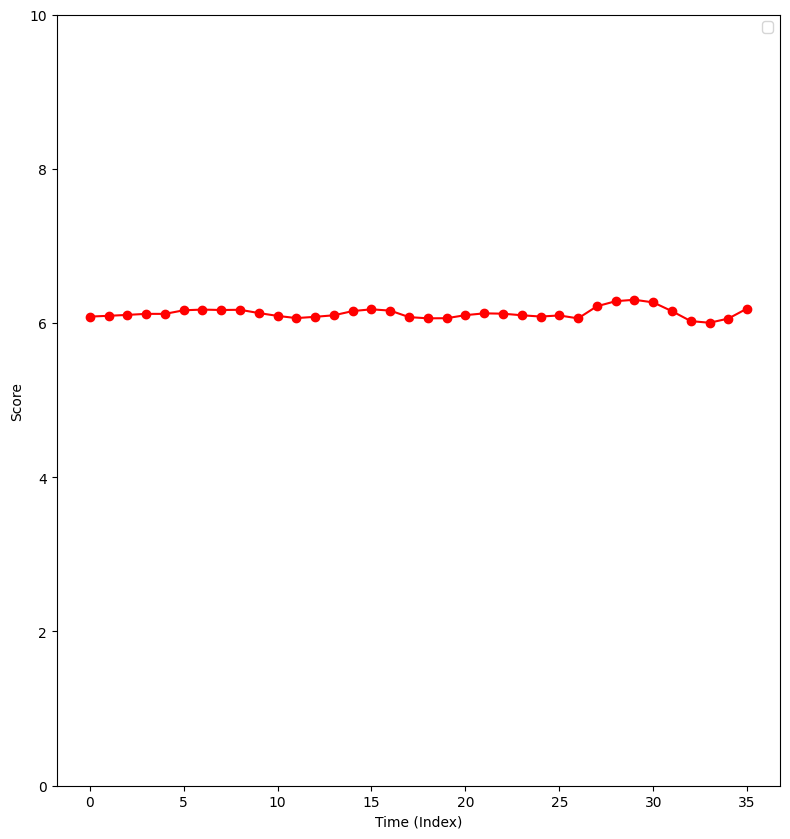

In [ ]:
!set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
from safetensors.torch import load_model, save_model
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
#PYTORCH_CUDA_ALLOC_CONF=expandable_segments

time_global = 0
score_global = 0

def perform_inference():
    # Initialize the model
    model = trainer.model
    model.eval()  # Set the model to evaluation mode

    # DataLoader for inference dataset
    inference_dataset = EEGDataset(root_dir='/content/drive/MyDrive/be_lab/data/inference2')  # Use the provided data directory
    inference_loader = DataLoader(inference_dataset, batch_size=4, collate_fn=pad_collate)

    # Check the size of the dataset
    print(f"Dataset size: {len(inference_dataset)}")

    # Try to get the first item from the dataset
    if len(inference_dataset) > 0:
        first_item = inference_dataset[0]
        print(f"First item keys: {first_item.keys()}")
    else:
        print("Dataset is empty. Check the dataset path and contents.")

    total_error = 0
    batches = 0
    total_score = 0
    scores = []

    # Perform inference
    with torch.no_grad():  # No need to track gradients
        for batch in inference_loader:
            batches += 1
            inputs = batch['input']
            inputs = inputs.to(torch.device('cuda:0'))
            true_labels = batch['label'].to(torch.device('cuda:0'))  # Assuming you want to compare against true labels
            outputs = model(inputs)
            print(outputs)
            print(true_labels)
            predicted_labels = outputs.to(torch.device('cuda:0'))
            total_error += abs(predicted_labels - true_labels).sum()
            total_score += (predicted_labels).sum()
            for x in predicted_labels:
                scores.append(x[0].cpu().numpy().item())
                scores.append(x[1].cpu().numpy().item())
                scores.append(x[2].cpu().numpy().item())
                scores.append(x[3].cpu().numpy().item())

    print("average_error = ", total_error / batches / 4)
    print("batches = ", batches)
    print("total_error = ", total_error)
    print("len of dataset = ", len(inference_dataset))

    concentration_time = len(inference_dataset) * 4 / 60
    average_score = total_score / (len(inference_dataset)+1)
    print("average = ",average_score)


    # Create time axis (list index)
    time = list(range(len(scores)))
    time = np.array(time)
    time = 5 * time * (1/60)
    time_global = len(time)*5/60
    score_global = average_score

    # Create a figure with a smaller width and larger height to accommodate the caption

    fig, ax = plt.subplots(figsize=(8, 10))

    # Plot the data
    ax.plot(time, scores, marker='o', linestyle='-', color='red')

    # Set the title and labels for the plot

    ax.set_xlabel('Time (Min)')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 10)

    # Add a legend
    ax.legend()

    # Adjust the layout to make space for the caption
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])

    # Save the figure with the caption
    plt.savefig('final1.png', bbox_inches='tight', dpi=150)

    return time_global, score_global




# Display the plot
plt.show()


time_global, score_global = perform_inference()

from google.colab import files
files.download('final1.png')


In [ ]:
!pip install google
!pip install google-api-python-client

In [ ]:
# 安裝必要的套件
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

# 授權並设置Google Drive和Google Docs API
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
import io
from googleapiclient.http import MediaIoBaseDownload
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials

In [ ]:


# 授權
auth.authenticate_user()

# 初始化Google Drive API
drive_service = build('drive', 'v3')

# 初始化Google Docs API
docs_service = build('docs', 'v1')

# 創建或打開名為analysis的Google Docs文档
def create_or_open_doc(doc_title):
    # 檢查是否已存在名為analysis的文档
    results = drive_service.files().list(q=f"name='{doc_title}' and mimeType='application/vnd.google-apps.document' and trashed=false").execute()
    items = results.get('files', [])
    if not items:
        # 創建新文檔
        doc = docs_service.documents().create(body={'title': doc_title}).execute()
        doc_id = doc['documentId']
    else:
        # 打開已存在的文檔
        doc_id = items[0]['id']
    return doc_id

# 將圖片設置為公開訪問
def make_file_public(file_id):
    drive_service.permissions().create(
        fileId=file_id,
        body={'role': 'reader', 'type': 'anyone'},
    ).execute()

# 添加圖片和文字到文檔
def add_content_to_doc(doc_id, text, image_path):
    # 上传图片到Google Drive
    file_metadata = {'name': image_path.split('/')[-1], 'mimeType': 'image/jpeg'}
    media = MediaFileUpload(image_path, mimetype='image/jpeg')
    image_file = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

    # 設置圖片為公開訪問
    make_file_public(image_file['id'])

    image_url = f"https://drive.google.com/uc?id={image_file['id']}"

    # 插入文字和圖片
    requests = [
        {'insertText': {'location': {'index': 1}, 'text': text + '\n'}},
        {'insertInlineImage': {'location': {'index': 1}, 'uri': image_url, 'objectSize': {'height': {'magnitude': 300, 'unit': 'PT'}, 'width': {'magnitude': 300, 'unit': 'PT'}}}},
        {'insertPageBreak': {'location': {'index': 1}}}  # 插入分頁符
    ]

    docs_service.documents().batchUpdate(documentId=doc_id, body={'requests': requests}).execute()

# 主程序
def write():
    doc_title = "| 專心測試結果"
    doc_id = create_or_open_doc(doc_title)

    # while True:
        # 請用戶上傳圖片和輸入文字
    from google.colab import files

    print("請上傳圖片")
    uploaded = files.upload()

    for filename in uploaded.keys():
        image_path = f"/content/{filename}"
        text = f' \n \n \n Concentration time = {time_global} min \n \n Average Score = {score_global} ' + '\n' + '\n'
        for i in range(20):
            text += '\n'
        add_content_to_doc(doc_id, text, image_path)
        print("圖片和文字已添加到文檔中。")

        # 持續等待新的输入
        # if input("按Enter繼續或输入'stop'结束: ").lower() == 'stop':
        #     break

write()


請上傳圖片


Saving final1 (1).png to final1 (1) (1).png
圖片和文字已添加到文檔中。
